# Tree-based Risk Models

In this case study, I am going to build tree based models to predict the 10-year risk of death of an individuals from the NHANES I epidemiology dataset (for a detailed description of this dataset is given at the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/)).

The following skils are used to build models:

- Dealing with Missing Data
  - Complete Case Analysis.
  - Imputation
- Decision Trees
  - Evaluation.
  - Regularization.
- Random Forests 
  - Hyperparameter Tuning.

## 1. Import necessary packages

In [1]:
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from util import load_data, cindex

## 2. Exploring data

Load the NHANES I epidemiology dataset. This dataset contains various features of hospital patients as well as their outcomes, i.e. whether or not they died within 10 years.

In [2]:
X_dev, X_test, y_dev, y_test = load_data(10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The dataset has been split into a development set (or dev set), which we will use to develop our risk models, and a test set, which we will use to test our models. Further, dev set will be split into a training and validation set, respectively to train and tune our models, using a 75/25 split.

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=10)

In [4]:
print(f"The size of X_train {X_train.shape}")
X_train.head()

The size of X_train (5147, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
1599,43.0,84.0,637.0,1.0,49.3,10.0,5.0,253.0,134.0,1.59,7.7,1.0,NaN,490.0,27.3,9.1,25.803007,34.0
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
1182,54.0,78.0,205.0,1.0,43.8,12.0,4.2,206.0,180.0,1.67,6.6,2.0,NaN,363.0,49.6,5.9,20.278410,34.0
6915,59.0,90.0,417.0,1.0,43.4,9.0,4.5,327.0,114.0,1.65,7.6,2.0,NaN,347.0,32.9,6.1,32.917744,78.0
500,34.0,80.0,385.0,1.0,77.7,9.0,4.1,197.0,64.0,1.74,7.3,2.0,NaN,376.0,17.0,8.2,30.743489,30.0


`y` will be whether or not the target died within 10 years.

In [5]:
y_train.head()

1599    False
2794     True
1182    False
6915    False
500     False
Name: time, dtype: bool

Let's see one of the examples and its outcome:

In [6]:
i = 10
print(X_train.iloc[i,:])
print("\nDied within 10 years? {}".format(y_train.loc[y_train.index[i]]))

Age                    67.000000
Diastolic BP           94.000000
Poverty index         114.000000
Race                    1.000000
Red blood cells        43.800000
Sedimentation rate     12.000000
Serum Albumin           3.700000
Serum Cholesterol     178.000000
Serum Iron             73.000000
Serum Magnesium         1.850000
Serum Protein           7.000000
Sex                     1.000000
Systolic BP           140.000000
TIBC                  311.000000
TS                     23.500000
White blood cells       4.300000
BMI                    17.481227
Pulse pressure         46.000000
Name: 5856, dtype: float64

Died within 10 years? True


#### Dealing with missing values
As we can see by looking at our data in `X_train`, that some of the data is missing which are marked as `NaN` ("not a number"). Missing data is a common occurrence in data analysis, that can be due to many reasons, such as measuring instrument malfunction, respondents not willing or not able to supply information, and errors in the data collection process.

Let's examine the missing data pattern by ploting `heatmap` of `X_train` and `X_val` to easily visualize the missing data pattern.

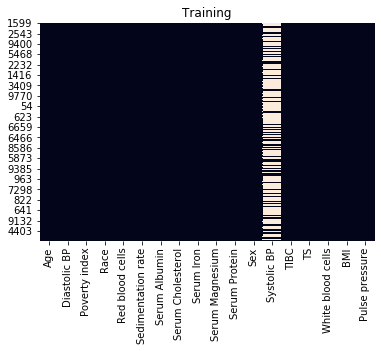

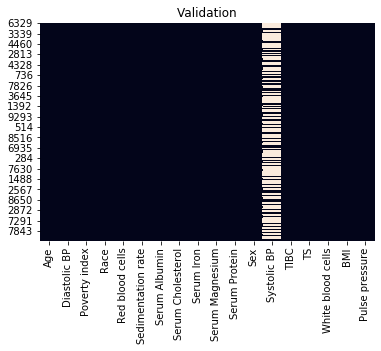

In [7]:
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

sns.heatmap(X_val.isnull(), cbar=False)
plt.title("Validation")
plt.show()

For each feature, represented as a column, values that are present are shown in black, and missing values are set in a light color.By analyzing this plot, we can see that many values are missing for systolic blood pressure (`Systolic BP`).

Let's find the fraction of cases with missing data. This will eventually help us decide how we handle this missing data in the future.

In [8]:
def fraction_rows_missing(df):
    '''
    Return percent of rows with any missing
    data in the dataframe. 
    '''
    return sum(df.isnull().any(axis=1))/df.shape[0]

In [9]:
print(f"The fraction of rows missing from X_train: {fraction_rows_missing(X_train):.3f}")
print(f"The fraction of rows missing from X_val: {fraction_rows_missing(X_val):.3f}")
print(f"The fraction of rows missing from X_test: {fraction_rows_missing(X_test):.3f}")

The fraction of rows missing from X_train: 0.699
The fraction of rows missing from X_val: 0.704
The fraction of rows missing from X_test: 0.000


Here, We can see that our train and validation sets have missing values, but fortunately our test set has complete cases. First, we will start with a **complete case analysis**, dropping all of the rows with any missing data.

In [10]:
X_train_dropped = X_train.dropna(axis='rows')
y_train_dropped = y_train.loc[X_train_dropped.index]
X_val_dropped = X_val.dropna(axis='rows')
y_val_dropped = y_val.loc[X_val_dropped.index]

## 3. Decision Trees

#### a. Complete case analysis (i.e. removing missing values)
Let's build decision tree classifier to see the performance of the model on the data with dropped all missing values.

In [11]:
dt = DecisionTreeClassifier(max_depth=None, random_state=10)
dt.fit(X_train_dropped, y_train_dropped)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

Now, we will evaluate this model using C-Index (i.e. Concordance index).

> C-Index evaluates the ability of a model to differentiate between different classes, by quantifying how often, when considering all pairs of patients (A, B), the model says that patient A has a higher risk score than patient B when, in the observed data, patient A actually died and patient B actually lived. In our case, our model is a binary classifier, where each risk score is either 1 (the model predicts that the patient will die) or 0 (the patient will live).
>
> More formally, defining _permissible_pairs_ of patients as pairs where the outcomes are different, _concordant_pairs_ as permissible pairs where the patient that died had a higher risk score (i.e. our model predicted 1 for the patient that died and 0 for the one that lived), and _risk_ties_ as permissible pairs where the risk scores were equal (i.e. our model predicted 1 for both patients or 0 for both patients), the C-Index is equal to:
>
> $$\text{C-Index} = \frac{\#\text{concordant_pairs} + 0.5\times \#\text{risk_ties}}{\#\text{permissible_pairs}}$$

In [12]:
y_train_preds = dt.predict_proba(X_train_dropped)[:, 1]
print(f"C-index for training data: {cindex(y_train_dropped.values, y_train_preds)}")

y_val_preds = dt.predict_proba(X_val_dropped)[:, 1]
print(f"C-index for validation data: {cindex(y_val_dropped.values, y_val_preds)}")

C-index for training data: 1.0
C-index for validation data: 0.5629321808510638


Clearly, this decision tree seems to be overfitting as it fits the training data so closely but it doesn't generalize well to other samples such as those from the validation set.

> The training C-index comes out to 1.0 because, when initializing `DecisionTreeClasifier`, we have left `max_depth` and `min_samples_split` unspecified. The resulting decision tree will therefore keep splitting as far as it can, which pretty much guarantees a pure fit to the training data.

In order to handle this, we can change some of the hyperparameters of the model and tune them. 

#### Tuning hyperparameters for Decision Trees

In [13]:
dt_hyperparams = {
    'criterion': 'entropy',
    'max_depth': 4,
    'min_samples_split': 2
}

In [14]:
dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train_dropped, y_train_dropped)

y_train_preds = dt_reg.predict_proba(X_train_dropped)[:, 1]
y_val_preds = dt_reg.predict_proba(X_val_dropped)[:, 1]
print(f"C-index of training data: {cindex(y_train_dropped.values, y_train_preds)}")
print(f"C-index of validation data: {cindex(y_val_dropped.values, y_val_preds)}")

C-index of training data: 0.7228201799128258
C-index of validation data: 0.6231964760638298


## 4. Random Forests

#### a. Complete case analysis (i.e. removing missing values)
No matter how you choose hyperparameters, a single decision tree is prone to overfitting. To resolve this problem, we can try **random forests**, which combine predictions from many different trees to create a robust classifier. 

In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(X_train_dropped, y_train_dropped)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

Now compute the C-Index for the random forest on the training and validation set.

In [16]:
y_train_rf_preds = rf.predict_proba(X_train_dropped)[:, 1]
print(f"C-index of training data: {cindex(y_train_dropped.values, y_train_rf_preds)}")

y_val_rf_preds = rf.predict_proba(X_val_dropped)[:, 1]
print(f"C-index of validation data: {cindex(y_val_dropped.values, y_val_rf_preds)}")

C-index of training data: 1.0
C-index of validation data: 0.6660488696808511


Training a random forest with the default hyperparameters results in a model that has better predictive performance than individual decision trees, but this model is overfitting.

We therefore need to tune the hyperparameters, to find a model that both has good predictive performance and minimizes overfitting.

The hyperparameters we adjust will be:

- `n_estimators`: the number of trees used in the forest.
- `max_depth`: the maximum depth of each tree.
- `min_samples_leaf`: the minimum number (if `int`) or proportion (if `float`) of samples in a leaf.

The approach we implement to tune the hyperparameters is known as a grid search which finds the best parameters using the C-Index that give good predictive performance.

#### Hyperparameters tuning with grid search

In [17]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparams, fixed_hyperparams={}):
    '''
    Conduct hyperparameter grid search on hold out validation set. Use holdout validation.
    Hyperparameters are input as a dictionary mapping each hyperparameter name to the
    range of values they should iterate over. Use the cindex function as an evaluation
    function.
    '''
    best_estimator = None
    best_hyperparams = {}
    
    # hold best running score
    best_score = 0.0

    # get list of param values
    lists = hyperparams.values()
    
    # get all param combinations
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)
    
    # iterate through param combinations
    for i, params in enumerate(param_combinations, 1):
        # fill param dict with params
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
            
        # create estimator with specified params
        estimator = clf(**param_dict, **fixed_hyperparams)

        # fit estimator
        estimator.fit(X_train_hp, y_train_hp)
        
        # get predictions on validation set
        preds = estimator.predict_proba(X_val_hp)
        
        # compute cindex for predictions
        estimator_score = cindex(y_val_hp, preds[:,1])

        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')

        # if new high score, update high score, best estimator
        # and best params 
        if estimator_score >= best_score:
                best_score = estimator_score
                best_estimator = estimator
                best_hyperparams = param_dict

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_estimator, best_hyperparams

In [18]:
# Ranges of chosen random forest hyperparameters 
hyperparams = {
    'n_estimators': [150, 200, 250, 300],
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
}

fixed_hyperparams = {
    'random_state': 10,
}

rf = RandomForestClassifier
best_rf, best_hyperparams = holdout_grid_search(rf, X_train_dropped, y_train_dropped,
                                                X_val_dropped, y_val_dropped, hyperparams,
                                                fixed_hyperparams)

print(f"Best hyperparameters:\n{best_hyperparams}")

y_train_best = best_rf.predict_proba(X_train_dropped)[:, 1]
print(f"C-index of training data: {cindex(y_train_dropped, y_train_best)}")

y_val_best = best_rf.predict_proba(X_val_dropped)[:, 1]
print(f"C-index of validation data: {cindex(y_val_dropped, y_val_best)}")

y_test_best = best_rf.predict_proba(X_test)[:, 1]
print(f"C-index of test data: {cindex(y_test.values, y_test_best)}")

[1/64] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 1}
Val C-Index: 0.6807014627659574

[2/64] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 2}
Val C-Index: 0.680219414893617

[3/64] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 3}
Val C-Index: 0.6797207446808511

[4/64] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 4}
Val C-Index: 0.6803523936170213

[5/64] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 1}
Val C-Index: 0.6736203457446809

[6/64] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 2}
Val C-Index: 0.672373670212766

[7/64] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 3}
Val C-Index: 0.6743184840425532

[8/64] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 4}
Val C-Index: 0.6769614361702128

[9/64] {'n_estimators': 150, 'max_depth': 5, 'min_samples_leaf': 1}
Val C-Index: 0.6743683510638298

[10/64] {'n_estimators': 150, 'max_depth': 5, 'min_samples_leaf': 2}
Val C-Index: 0.675132978

#### EDA on features

We have now built and optimized a random forest model on given data. However, there was still a drop in test C-Index. This might be because of more than half of the data are of missing values for systolic blood pressure. Instead, we can try filling in, or imputing, these values. 

First, let's see if our data is missing at random or not. Let's plot histograms of the dropped rows against each of the covariates (aside from systolic blood pressure) to see if there is a trend. Compare these to the histograms of the feature in the entire dataset. Try to see if one of the covariates has a signficantly different distribution in the two subsets.

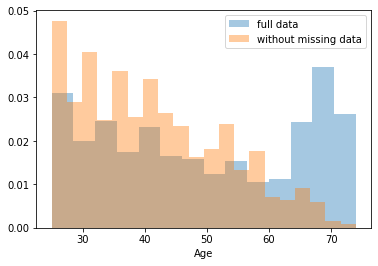

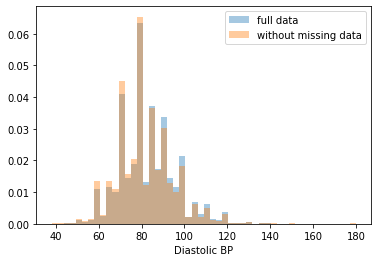

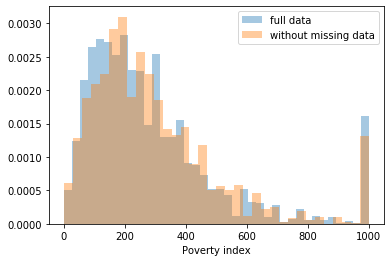

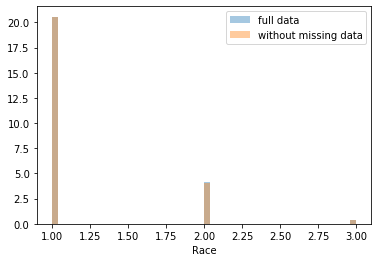

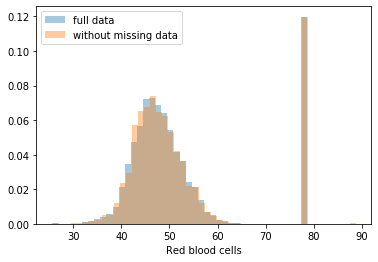

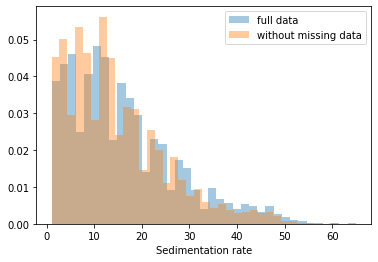

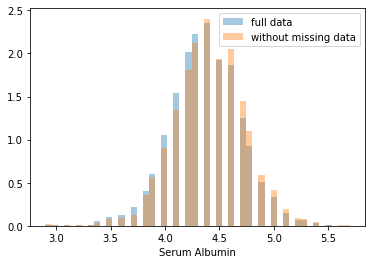

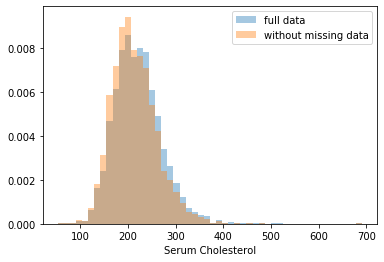

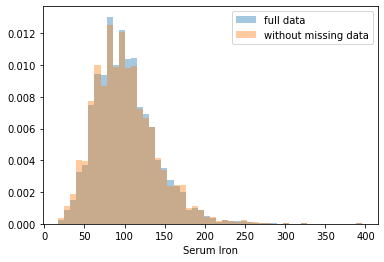

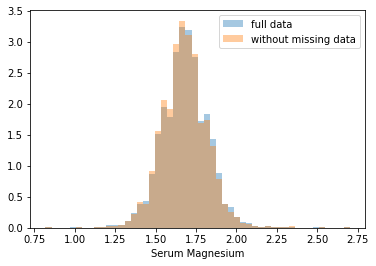

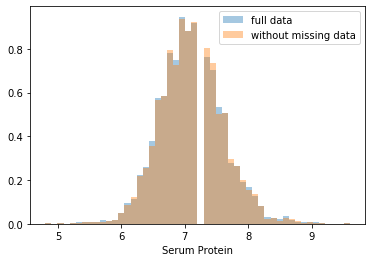

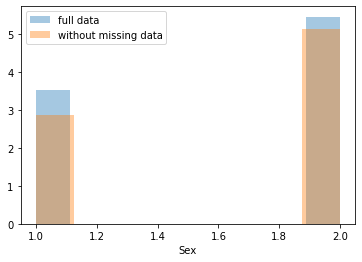

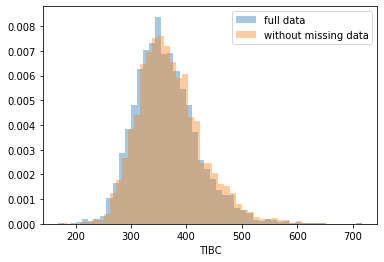

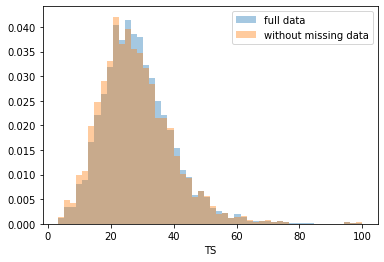

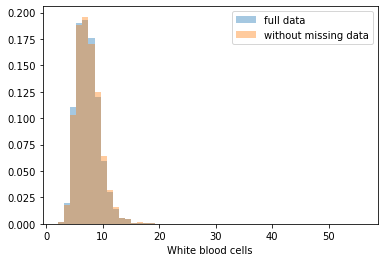

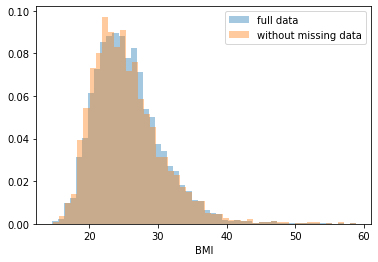

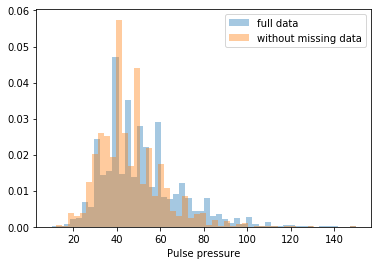

In [19]:
dropped_rows = X_train[X_train.isnull().any(axis=1)]
columns_except_Systolic_BP = [col for col in X_train.columns if col not in ['Systolic BP']]

for col in columns_except_Systolic_BP:
    sns.distplot(X_train.loc[:, col], norm_hist=True, kde=False, label='full data')
    sns.distplot(dropped_rows.loc[:, col], norm_hist=True, kde=False, label='without missing data')
    plt.legend()
    plt.show()

Most of the covariates are distributed similarly whether or not we have discarded rows with missing data. In other words missingness of the data is independent of these covariates.

If this had been true across *all* covariates, then the data would have been said to be **missing completely at random (MCAR)**.

But when considering the age covariate, we see that much more data tends to be missing for patients over 65. The reason could be that blood pressure was measured less frequently for old people to avoid placing additional burden on them.

As missingness is related to one or more covariates, the missing data is said to be **missing at random (MAR)**.

Based on the information we have, there is however no reason to believe that the _values_ of the missing data — or specifically the values of the missing systolic blood pressures — are related to the age of the patients. If this was the case, then this data would be said to be **missing not at random (MNAR)**.

#### Error analysis

Using the information from the plots above, let's try to find a subgroup of the test data on which the model performs poorly.

In [20]:
def bad_subset(forest, X_test, y_test):
    # define mask to select large subset with poor performance
    mask = X_test['Age'] > 65.0
    
    X_subgroup = X_test[mask]
    y_subgroup = y_test[mask]
    subgroup_size = len(X_subgroup)

    y_subgroup_preds = forest.predict_proba(X_subgroup)[:, 1]
    performance = cindex(y_subgroup.values, y_subgroup_preds)
    
    return performance, subgroup_size

In [21]:
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print(f"Subgroup size: {subgroup_size}, C-Index: {performance}")

Subgroup size: 439, C-Index: 0.6835146761133604


#### b. Mean imputation (filling missing values by mean strategy)

Seeing that the data is not missing completely at random, we can handle the missing values by replacing them with substituted values based on the other values that we have. This is known as imputation. The first imputation strategy that we will use is **mean substitution**: we will replace the missing values for each feature with the mean of the available values.

In [22]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_mean_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_mean_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

In [23]:
# Ranges of chosen random forest hyperparameters 
hyperparams = {
    'n_estimators': [150, 200, 250, 300],
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
}

rf = RandomForestClassifier
rf_mean_imputed, best_hyperparams_mean_imputed = holdout_grid_search(rf, X_train_mean_imputed, y_train,
                                                                     X_val_mean_imputed, y_val,
                                                                     hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")

y_train_best = rf_mean_imputed.predict_proba(X_train_mean_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_mean_imputed.predict_proba(X_val_mean_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_mean_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/64] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 1}
Val C-Index: 0.7378919049201045

[2/64] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 2}
Val C-Index: 0.7378723626012129

[3/64] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 3}
Val C-Index: 0.737671510990383

[4/64] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 4}
Val C-Index: 0.7375510000238851

[5/64] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 1}
Val C-Index: 0.7454222117996522

[6/64] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 2}
Val C-Index: 0.7459911104162731

[7/64] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 3}
Val C-Index: 0.745231131348268

[8/64] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 4}
Val C-Index: 0.7450291940530552

[9/64] {'n_estimators': 150, 'max_depth': 5, 'min_samples_leaf': 1}
Val C-Index: 0.7464612117540534

[10/64] {'n_estimators': 150, 'max_depth': 5, 'min_samples_leaf': 2}
Val C-Index: 0.746004138

#### c. Multivariate feature imputation (filling missing values by multivariate feature strategy)

Next, we will apply another imputation strategy, known as **multivariate feature imputation**. With this strategy, for each feature that is missing values, a regression model is trained to predict observed values based on all of the other features, and the missing values are inferred using this model.

In [24]:
imputer = IterativeImputer(random_state=0, sample_posterior=False, max_iter=1, min_value=0)
imputer.fit(X_train)
X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

[IterativeImputer] Early stopping criterion not reached.


In [25]:
# Ranges of chosen random forest hyperparameters 
hyperparams = {
    'n_estimators': [150, 200, 250, 300],
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
}
rf = RandomForestClassifier
rf_imputed, best_hyperparams_imputed = holdout_grid_search(rf, X_train_imputed, y_train,
                                                           X_val_imputed, y_val,
                                                           hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")

y_train_best = rf_imputed.predict_proba(X_train_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_imputed.predict_proba(X_val_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/64] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 1}
Val C-Index: 0.7335339678072866

[2/64] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 2}
Val C-Index: 0.733755447421391

[3/64] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 3}
Val C-Index: 0.7338140743780657

[4/64] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 4}
Val C-Index: 0.7336707640395276

[5/64] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 1}
Val C-Index: 0.7410403896304113

[6/64] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 2}
Val C-Index: 0.7413291816762533

[7/64] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 3}
Val C-Index: 0.7409926195175653

[8/64] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 4}
Val C-Index: 0.7403889790006927

[9/64] {'n_estimators': 150, 'max_depth': 5, 'min_samples_leaf': 1}
Val C-Index: 0.7439760802016767

[10/64] {'n_estimators': 150, 'max_depth': 5, 'min_samples_leaf': 2}
Val C-Index: 0.74295987

## 5. Comparison

For good measure, retest on the subgroup (on which model performed poorly earlier) to see if your new models do better.

In [26]:
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print(f"C-index (no imputation): {performance}")

performance, subgroup_size = bad_subset(rf_mean_imputed, X_test, y_test)
print(f"C-index (mean imputation): {performance}")

performance, subgroup_size = bad_subset(rf_imputed, X_test, y_test)
print(f"C-index (multivariate feature imputation): {performance}")

C-index (no imputation): 0.6835146761133604
C-index (mean imputation): 0.6978955802968961
C-index (multivariate feature imputation): 0.6898405870445344


We should see that avoiding complete case analysis (i.e. analysis only on observations for which there is no missing data) allows our model to generalize a bit better. Remember to examine your missing cases to judge whether they are missing at random or not!

## 6. Interpretability of models using SHAP

Using a random forest has improved results, but we've lost some of the natural interpretability of trees. Let's try to explain the predictions using slightly more sophisticated techniques. 

The choise to apply **SHAP (SHapley Additive exPlanations) **, a cutting edge method that explains predictions made by black-box machine learning models (i.e. models which are too complex to be understandable by humans as is).

> Given a prediction made by a machine learning model, SHAP values explain the prediction by quantifying the additive importance of each feature to the prediction. SHAP values have their roots in cooperative game theory, where Shapley values are used to quantify the contribution of each player to the game.
> 
> Although it is computationally expensive to compute SHAP values for general black-box models, in the case of trees and forests there exists a fast polynomial-time algorithm. For more details, see the [TreeShap paper](https://arxiv.org/pdf/1802.03888.pdf).

We'll use the [shap library](https://github.com/slundberg/shap) to do this for our random forest model. Now identify the most at risk individuals in the test set according to our model.

In [27]:
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = rf_imputed.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
5493,67.0,80.0,30.0,1.0,77.7,59.0,3.4,231.0,36.0,1.40,6.3,1.0,170.0,202.0,17.8,8.4,17.029470,90.0,0.617341
6337,69.0,80.0,233.0,1.0,77.7,48.0,4.2,159.0,87.0,1.81,6.9,1.0,146.0,291.0,29.9,15.2,17.931276,66.0,0.561105
1017,65.0,98.0,16.0,1.0,49.4,30.0,3.4,124.0,129.0,1.59,7.7,1.0,184.0,293.0,44.0,5.9,30.858853,86.0,0.551578
6609,72.0,90.0,75.0,1.0,29.3,59.0,3.9,216.0,64.0,1.63,7.4,2.0,182.0,322.0,19.9,9.3,22.281793,92.0,0.549210
2044,74.0,80.0,83.0,1.0,47.6,19.0,4.2,205.0,72.0,1.71,6.9,1.0,180.0,310.0,23.2,10.8,20.900101,100.0,0.548627


We can use SHAP values to try and understand the model output on specific individuals using force plots.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


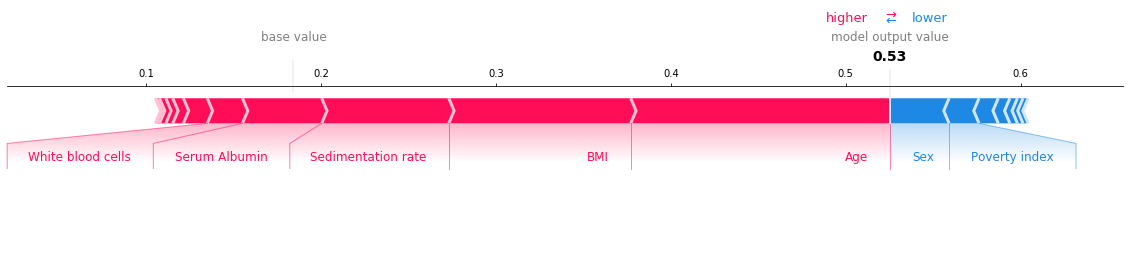

In [28]:
explainer = shap.TreeExplainer(rf_imputed)
i = 10
shap_value = explainer.shap_values(X_test.loc[X_test_risk.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

How to read this chart:
- The red sections on the left are features which push the model towards the final prediction in the positive direction (i.e. a higher Age increases the predicted risk).
- The blue sections on the right are features that push the model towards the final prediction in the negative direction (if an increase in a feature leads to a lower risk, it will be shown in blue).

We can also use SHAP values to understand the model output in aggregate. Next, initialize the SHAP values.

In [29]:
shap_values = shap.TreeExplainer(rf_imputed).shap_values(X_test)[1]

Let's see a summary plot of the SHAP values for each feature on each of the test examples. The colors indicate the value of the feature.

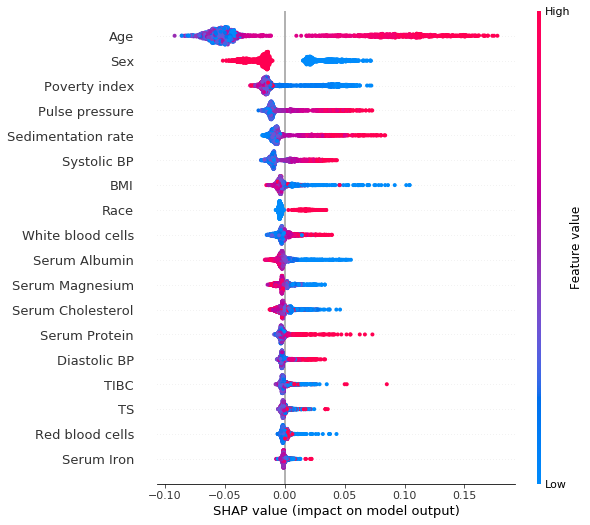

In [30]:
shap.summary_plot(shap_values, X_test)

Clearly we see that being a woman (`sex = 2.0`, as opposed to men for which `sex = 1.0`) has a negative SHAP value, meaning that it reduces the risk of dying within 10 years. High age and high systolic blood pressure have positive SHAP values, and are therefore related to increased mortality. 

It can be seen how features interact using dependence plots. These plot the SHAP value for a given feature for each data point, and color the points in using the value for another feature. This lets us begin to explain the variation in SHAP value for a single value of the main feature.

Moving forward to see the interaction between Age and Sex.

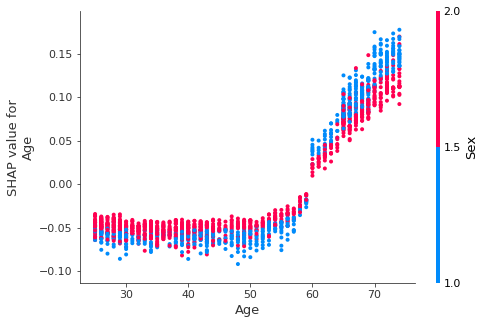

In [31]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='Sex')

We see that while Age > 50 is generally bad (positive SHAP value), being a woman generally reduces the impact of age. This makes sense since we know that women generally live longer than men.

Let's now look at poverty index and age.

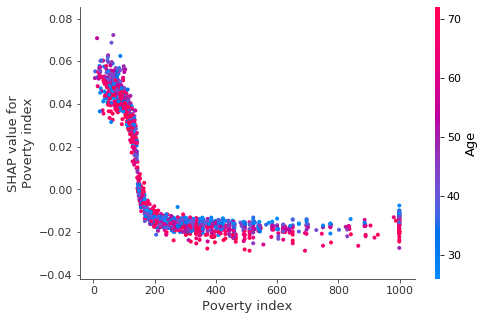

In [32]:
shap.dependence_plot('Poverty index', shap_values, X_test, interaction_index='Age')

We see that the impact of poverty index drops off quickly, and for higher income individuals age begins to explain much of variation in the impact of poverty index.

## 7. Conclusion

In conclusion, we can say that Random Forest algorithm gives better predictive performance over Decision Trees by handling missing values with imputation strategy. Also, SHAP method allows us to interpret complex Random Forest model to gain insights of feature correlation.